In [6]:
import pandas as pd
from pymongo import MongoClient as mc
import seaborn as sns
import time

In [7]:
start_time=time.time()
myClient = mc("mongodb://localhost:27017")
myDb = myClient['db_test']
myCol = myDb['checkout']
myQuery=myCol.aggregate([
    { "$match": { "target": "vergani" } },
    {"$unwind":"$cart"},
    {
        "$group": {
            "_id" : {'$dateToString': {"format": '%Y-%m-%d', "date": '$date'}},
            "Orders":{"$sum":1},
            "Price": {"$sum":"$cart.price"}}
       },
       
#     {"$sort":{"Price" : -1}},
    {"$project": {"_id":1,"Price":1,"Orders":1,"AOV":{"$divide":["$Price","$Orders"]}}}
])

dataToPerform = pd.DataFrame(myQuery).rename({'_id':'Dates'}, axis=1)
print(dataToPerform)
mongodbTime=time.time() - start_time

         Dates  Orders  Price         AOV
0   2019-08-12       1   40.0   40.000000
1   2019-07-30       7  107.2   15.314286
2   2019-08-04       3   65.5   21.833333
3   2019-08-03       9  304.7   33.855556
4   2019-07-19       6  257.5   42.916667
..         ...     ...    ...         ...
58  2019-06-11      10  334.6   33.460000
59  2019-06-16       8  365.6   45.700000
60  2019-07-16       3  374.0  124.666667
61  2019-07-08      17  724.9   42.641176
62  2019-06-12       8  233.3   29.162500

[63 rows x 4 columns]


In [8]:
start_time1=time.time()
#normalizing data 
data = pd.json_normalize(list(myCol.find()), record_path='cart',meta=['target','date'])


data = data.query("target == 'vergani'")
dates = pd.to_datetime(data['date']).dt.date
prices = pd.Series(data['price'])
target = pd.Series(data['target'])

dataToPerform =pd.DataFrame({'Dates':dates,'Price':prices, "Orders":target}).groupby('Dates').aggregate({'Price':'sum','Orders':'size'})
dataToPerform.eval('AOV = Price / Orders', inplace=True)
dataToPerform = dataToPerform.reset_index()
print(dataToPerform)
pythonTime=time.time() - start_time1

         Dates   Price  Orders        AOV
0   2019-06-11   334.6      10  33.460000
1   2019-06-12   233.3       8  29.162500
2   2019-06-13   453.3       8  56.662500
3   2019-06-14   325.4       8  40.675000
4   2019-06-15   319.0       6  53.166667
..         ...     ...     ...        ...
58  2019-08-08  2204.7      43  51.272093
59  2019-08-09   833.3      18  46.294444
60  2019-08-10   213.6       6  35.600000
61  2019-08-11   401.2      14  28.657143
62  2019-08-12    40.0       1  40.000000

[63 rows x 4 columns]


In [9]:
if mongodbTime<pythonTime:
    print("Mongo db is faster")
else:
    print("Python i faster")

Mongo db is faster


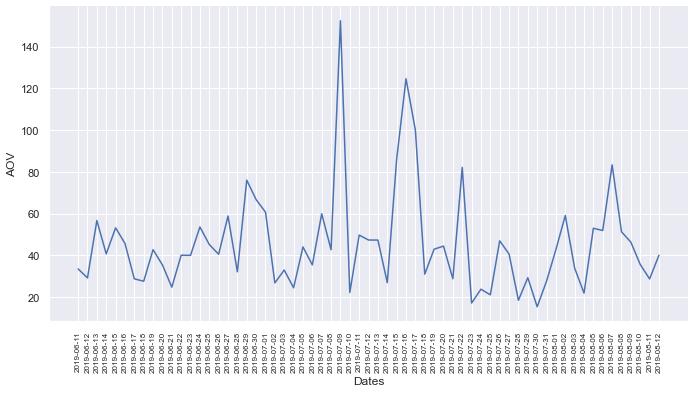

In [10]:
sns.set()
ax=sns.relplot(x='Dates',y='AOV',data=dataToPerform,kind='line',aspect = 2) 
ax.set(xticks=dataToPerform.Dates)
ax.set_xticklabels(dataToPerform.Dates,rotation=90,fontsize=8)